# Categorize nationality of last names by RNN

From http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [121]:
import tensorflow as tf
import keras
sess = tf.InteractiveSession()

keras.__version__, tf.__version__

('2.0.2', '1.0.0')

In [9]:
! wget https://download.pytorch.org/tutorial/data.zip
! rm -R data
! unzip data.zip
! ls data

--2017-03-31 14:38:45--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org... 13.32.176.115, 13.32.176.191, 13.32.176.164, ...
Connecting to download.pytorch.org|13.32.176.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: 'data.zip.2'

data.zip.2          100%[=====================>]   2.75M  6.43MB/s   in 0.4s   

2017-03-31 14:38:46 (6.43 MB/s) - 'data.zip.2' saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japane

In [10]:
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories

18

In [392]:
import pandas as pd

name_nations = pd.DataFrame([
    (nation,name)
    for nation, list_of_names in category_lines.items()
    for name in list_of_names], columns=['nation', 'name']
)

name_nations = name_nations\
    .assign(nation=lambda df: df.nation.astype('category'))\
    .assign(y=lambda df: df.nation.cat.codes
)

original_name_nations = name_nations.copy()

print(name_nations.nation.cat.categories)

name_nations = name_nations.sample(n=name_nations.shape[0])

name_nations.head(10)

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')


,nation,name,y
3568,English,Clifton,4
6231,English,Swann,4
4457,English,Guest,4
4125,English,Fenlon,4
9840,Japanese,Yamaguchiya,10
9345,Japanese,Masudu,10
19114,Russian,Yuzhanov,14
107,Arabic,Baba,0
17997,Russian,Tupalo,14
15245,Russian,Likhovskikh,14


In [113]:
import numpy as np

# Find letter index from all_letters, e.g. "a" = 1
# we'll reserve 0 for padding symbol
def letterToIndex(letter):
    return all_letters.find(letter) + 1

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = np.zeros(shape=(1, n_letters + 1))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, max_length=max_name_length):
    tensor = np.zeros(shape=(max_length, n_letters + 1))
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').shape)
print(np.where(lineToTensor('Jones')))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
(19, 58)
(array([0, 1, 2, 3, 4]), array([36, 15, 14,  5, 19]))


## Fighting the dataset imbalance by sampling

In [395]:
name_nations.groupby('nation').size().to_frame('count').sort_values('count', ascending=False)

,count
nation,
Russian,9408
English,3668
Arabic,2000
Japanese,991
German,724
Italian,709
Czech,519
Spanish,298
Dutch,297


In [394]:
name_counts = name_nations.groupby('name').nation.apply(list)
name_counts[name_counts.apply(len) == 2].head(10)

name
Abello            [Spanish, Italian]
Abraham            [English, French]
Abreu          [Portuguese, Spanish]
Adams             [English, Russian]
Adamson           [English, Russian]
Aitken           [Scottish, English]
Albuquerque    [Portuguese, Spanish]
Alexander        [English, Scottish]
Allan            [English, Scottish]
Allard             [English, French]
Name: nation, dtype: object

In [297]:
n_samples_per_nation = 8000

balanced_name_nations = pd.concat([
    name_nations.query('nation == "{}"'.format(n)).sample(n_samples_per_nation, replace=True)
    for n in name_nations.nation.unique()
])

balanced_name_nations.groupby('nation').size()

nation
Arabic        8000
Chinese       8000
Czech         8000
Dutch         8000
English       8000
French        8000
German        8000
Greek         8000
Irish         8000
Italian       8000
Japanese      8000
Korean        8000
Polish        8000
Portuguese    8000
Russian       8000
Scottish      8000
Spanish       8000
Vietnamese    8000
dtype: int64

In [298]:
name_nations = balanced_name_nations

training_seqs = np.stack([lineToTensor(name) for name in name_nations.name])
training_seqs.shape

(144000, 19, 58)

In [299]:
seq_length = max_name_length
targets = pd.get_dummies(name_nations.y).values

print(training_seqs[:3, :, 0])
print(targets[:3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]]
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [300]:
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

num_hidden = 128

model = Sequential()
model.add(
    SimpleRNN(num_hidden, input_shape=(max_name_length, n_letters + 1), 
         activation='sigmoid'))

model.add(Dense(n_categories))

model.add(Activation('softmax'))

optimizer = Adam(lr=0.005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 128)               23936     
_________________________________________________________________
dense_15 (Dense)             (None, 18)                2322      
_________________________________________________________________
activation_10 (Activation)   (None, 18)                0         
Total params: 26,258.0
Trainable params: 26,258.0
Non-trainable params: 0.0
_________________________________________________________________


In [301]:
fit_logs = model.fit(
    training_seqs, targets, batch_size=128, epochs=20, verbose=2, validation_split=.1)

Train on 129600 samples, validate on 14400 samples
Epoch 1/100
16s - loss: 2.6719 - acc: 0.1018 - val_loss: 7.5226 - val_acc: 0.0000e+00
Epoch 2/100
18s - loss: 2.3354 - acc: 0.1970 - val_loss: 7.3984 - val_acc: 0.0000e+00
Epoch 3/100
19s - loss: 2.1031 - acc: 0.2697 - val_loss: 8.3352 - val_acc: 0.0000e+00
Epoch 4/100
20s - loss: 1.8739 - acc: 0.3374 - val_loss: 8.8991 - val_acc: 0.0000e+00
Epoch 5/100
21s - loss: 1.6784 - acc: 0.3979 - val_loss: 9.3072 - val_acc: 0.0000e+00
Epoch 6/100
24s - loss: 1.4957 - acc: 0.4743 - val_loss: 9.9202 - val_acc: 0.0000e+00
Epoch 7/100
23s - loss: 1.3456 - acc: 0.5473 - val_loss: 9.6810 - val_acc: 0.0000e+00
Epoch 8/100
23s - loss: 1.1947 - acc: 0.6096 - val_loss: 9.4827 - val_acc: 0.0000e+00
Epoch 9/100
23s - loss: 1.0817 - acc: 0.6516 - val_loss: 10.0184 - val_acc: 0.0000e+00
Epoch 10/100
22s - loss: 0.9745 - acc: 0.6887 - val_loss: 9.8017 - val_acc: 0.0524
Epoch 11/100
22s - loss: 0.8989 - acc: 0.7143 - val_loss: 9.8950 - val_acc: 0.0616
Epoch 12

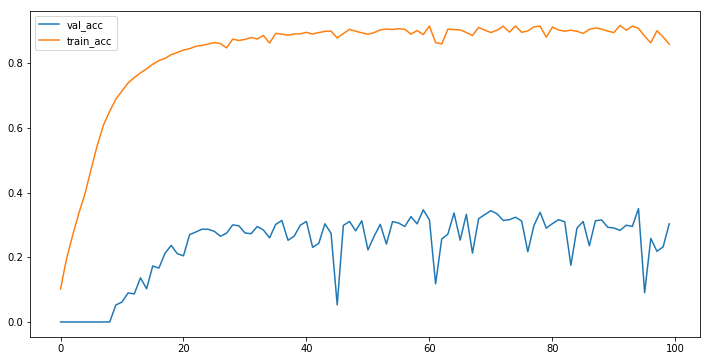

In [302]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(12, 6))
plt.plot(fit_logs.history['val_acc'], label='val_acc')
plt.plot(fit_logs.history['acc'], label='train_acc')
plt.legend();

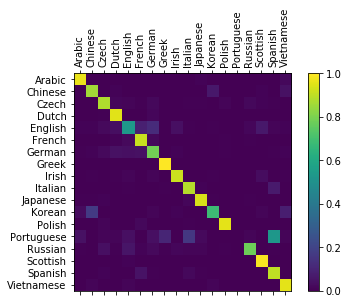

In [303]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Keep track of correct guesses in a confusion matrix
confusion = np.zeros((n_categories, n_categories))

predicted_targets = model.predict(training_seqs, verbose=0)

for target_index, predicted_index in zip(targets.argmax(axis=1), predicted_targets.argmax(axis=1)):
    confusion[target_index][predicted_index] += 1

row_normalised_confusion = np.array([r / r.sum() for r in confusion])

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(row_normalised_confusion)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [304]:
print(confusion.diagonal().sum() / confusion.sum())

0.829534722222


## Test with "out of sample" examples

In [428]:
def predict_nationality_probs(name, topn=5, model=model):
    predicted_probs = model.predict(np.array([lineToTensor(name)]), verbose=0)
    return pd.DataFrame(predicted_probs.reshape((-1, 1)), index=name_nations.nation.cat.categories, columns=['prob'])\
        .sort_values(by='prob', ascending=False).head(topn)

def train_name_containing(pattern):
    return original_name_nations[original_name_nations.name.str.contains(pattern)]

predict_nationality_probs("Macron")

,prob
French,0.314725
German,0.257561
English,0.254238
Czech,0.118958
Russian,0.047033


In [435]:
predict_nationality_probs("Marciniak")

,prob
Czech,0.644995
Polish,0.186342
Russian,0.150023
English,0.011958
Italian,0.003247


In [441]:
print(train_name_containing("olik"))
predict_nationality_probs("Frolik")

        nation         name   y
2694     Czech      Sokolik   2
10335  Russian    Abolikhin  14
16736  Russian    Polikanov  14
16737  Russian   Polikarpov  14
16738  Russian  Polikashkin  14


,prob
Polish,0.998058
Russian,0.001080
Czech,0.000749
Italian,0.000082
Japanese,0.000012


In [447]:
predict_nationality_probs("Ming")

,prob
Chinese,0.990100
Korean,0.002496
Vietnamese,0.002473
English,0.002348
Italian,0.001307


In [397]:
predict_nationality_probs("Soarez")

,prob
Spanish,0.996003
English,0.001847
Russian,0.001369
Italian,0.000359
Greek,0.000182


In [448]:
predict_nationality_probs("Illan")

,prob
Irish,0.507976
French,0.263601
Russian,0.103888
English,0.076266
German,0.021601


In [452]:
print(train_name_containing("akis"))

predict_nationality_probs("Georgakis")


         nation           name   y
7758      Greek       Anetakis   7
7770      Greek       Batsakis   7
7777      Greek  Brisimitzakis   7
7779      Greek    Calogerakis   7
7799      Greek        Demakis   7
7808      Greek       Drivakis   7
7812      Greek        Forakis   7
7814      Greek       Fourakis   7
7827      Greek  Grammatakakis   7
7845      Greek    Karnoupakis   7
7868      Greek    Leontarakis   7
7878      Greek   Manoukarakis   7
7907      Greek       Petrakis   7
9726   Japanese      Takishida  10
9727   Japanese      Takishita  10
11588   Russian          Bakis  14


,prob
Greek,9.987202e-01
Russian,9.625825e-04
Spanish,2.992244e-04
English,1.806496e-05
Arabic,4.270991e-08


In [399]:
predict_nationality_probs("Soldatov")

,prob
Russian,0.997543
Czech,0.001478
English,0.000587
Japanese,0.000303
German,0.000041


In [401]:
predict_nationality_probs("Infante")

,prob
Scottish,0.682393
English,0.260273
Russian,0.021520
French,0.018721
Czech,0.013884


In [402]:
predict_nationality_probs("Weiss")

,prob
German,0.904989
English,0.056325
Czech,0.028310
Russian,0.005710
French,0.002715


In [403]:
predict_nationality_probs("Dzhougashvilli")

,prob
Russian,0.416160
Czech,0.331542
Greek,0.214100
Spanish,0.032703
English,0.003122


In [453]:
predict_nationality_probs("Shevelyov")

,prob
Russian,0.996419
Czech,0.001952
English,0.000896
Japanese,0.000414
Italian,0.000169


In [404]:
predict_nationality_probs("Durand")

,prob
French,0.995687
Russian,0.001225
Italian,0.000915
English,0.000611
German,0.000592


In [421]:
train_name_containing("Durand")

,nation,name,y
3867,English,Durand,4
6837,French,Durand,5


In [429]:
predict_nationality_probs("Allain")

,prob
English,0.647855
German,0.256748
Russian,0.049486
Czech,0.024357
Dutch,0.008764


In [431]:
train_name_containing("Alla")

,nation,name,y
3150,English,Alladee,4
3151,English,Allam,4
3152,English,Allan,4
3153,English,Allard,4
3154,English,Allaway,4
6756,French,Allard,5
19641,Scottish,Allan,15


In [433]:
train_name_containing("lain")

,nation,name,y
3521,English,Chamberlain,4
7027,French,Voclain,5
8000,Irish,Dubhshlaine,8
8065,Irish,Mclain,8
8141,Irish,Pharlain,8
14123,Russian,Hudilainen,14
